In [1]:
# Load needed packages
import numpy as np
import os
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette # For palette of colors
import math
from scipy import stats
from matplotlib import rc
import ROOT 

# Latex rendering for plotting
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

# Define color palette
col = palette.brewer['RdYlBu'][10] #(8)

# Convert HTML color code to RGB
from PIL import ImageColor
ImageColor.getcolor(col[9], "RGB")

# Define folder to save plots
dir_name = './plots_drift'
if not os.path.isdir(dir_name):
    os.mkdir(dir_name)

Welcome to JupyROOT 6.22/02


<ipython-input-1-7ea47b760f4e>:16: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\boldmath']


## Load dataset (conversion+data)

In [2]:
# LOAD CONVERSION DATASET 

path_conv = 'Data/conversion.dat'
col_name = ['T','R/R0','rel_error']
df_conv = pd.read_csv(path_conv, sep="\t", header=None, names=col_name,skiprows=2)


# LOAD DRIFT DATASET

path_co = 'Data/cooling_new.dat'
path_he = 'Data/heating.dat'
col_name = ['ID','Tcf','Rv','Vout']
df_co = pd.read_csv(path_co, sep="\t", header=None, names=col_name,skiprows=4)
df_he = pd.read_csv(path_he, sep="\t", header=None, names=col_name,skiprows=4)


# BRIDGE RESISTANCES WITH ERRORS 

R1 = 11.98*10**3 # K Ohm
err_R1 = 1/np.sqrt(3)*np.sqrt( (0.009*R1)**2 + 0.001**2 )
R2 = 12.00*10**3 # K Ohm
err_R2 = 1/np.sqrt(3)*np.sqrt( (0.009*R2)**2 + 0.001**2 )

print('R1:', R1,'+-',err_R1)
print('R2:', R2,'+-',err_R2)

R1: 11980.0 +- 62.24990602670283
R2: 12000.0 +- 62.3538290751525


In [3]:
# Define helipot resistance error
df_co['err_Rv'] = 0.2/np.sqrt(12) 
df_he['err_Rv'] = 0.2/np.sqrt(12) 

# Define Vout measurement error
df_co['err_Vout'] = (1/np.sqrt(3))*np.sqrt( (0.0015*df_co['Vout'])**2 + 0.2**2 )
df_he['err_Vout'] = (1/np.sqrt(3))*np.sqrt( (0.0015*df_he['Vout'])**2 + 0.2**2 )

# Convert helipot resistance to Pt100-c resistance 
# with associated error by propagation and relative error
df_co['RT'] = R2/R1 * df_co['Rv']
df_co['err_RT'] = np.sqrt( (R2/R1 * df_co['err_Rv'])**2 + (df_co['Rv']/R1 * err_R2)**2 
                       + (R2/R1**2 * df_co['Rv'] * err_R1)**2 )
df_co['rel_err_RT'] = df_co['err_RT']/df_co['RT'] 


df_he['RT'] = R2/R1 * df_he['Rv']
df_he['err_RT'] = np.sqrt( (R2/R1 * df_he['err_Rv'])**2 + (df_he['Rv']/R1 * err_R2)**2 
                       + (R2/R1**2 * df_he['Rv'] * err_R1)**2 )
df_he['rel_err_RT'] = df_he['err_RT']/df_he['RT'] 


df_he.describe()

,ID,Tcf,Rv,Vout,err_Rv,err_Vout,RT,err_RT,rel_err_RT
count,30.000000,29.000000,30.000000,30.000000,3.000000e+01,30.000000,30.000000,30.000000,30.000000
mean,1214.400000,111.642814,32.823333,406.123333,5.773503e-02,0.370198,32.878130,0.248650,0.007578
std,606.843308,17.247564,6.103288,12.552282,2.117255e-17,0.010315,6.113477,0.043644,0.000089
min,185.000000,76.710000,22.000000,374.000000,5.773503e-02,0.343861,22.036728,0.171953,0.007460
25%,842.500000,102.203000,29.125000,400.000000,5.773503e-02,0.365148,29.173623,0.222045,0.007515
50%,1130.500000,111.470000,32.250000,407.500000,5.773503e-02,0.371316,32.303840,0.244327,0.007563
75%,1585.000000,122.740000,36.750000,414.750000,5.773503e-02,0.377288,36.811352,0.276621,0.007611
max,2498.000000,144.194000,45.000000,424.000000,5.773503e-02,0.384923,45.075125,0.336244,0.007803


In [4]:
# Add columns to CONVERSION DATASET in order to associate errors

R0 = 100
df_conv['R'] = df_conv['R/R0']*R0
df_conv['Delta_R'] = df_co['rel_err_RT'].mean() * df_conv['R'] 
df_conv['Delta_T'] = df_conv['Delta_R']/(df_conv['rel_error']*R0)

df_conv['rel_err_T'] = df_conv['Delta_T']/df_conv['T']

df_conv.describe()

,T,R/R0,rel_error,R,Delta_R,Delta_T,rel_err_T
count,1055.000000,1055.000000,1045.000000,1055.000000,1055.000000,1045.000000,1045.000000
mean,80.679763,0.213108,0.003416,21.310827,0.160618,0.380184,0.003907
std,62.404756,0.251305,0.001247,25.130538,0.189407,0.422445,0.001363
min,13.000000,0.001230,0.000203,0.123000,0.000927,0.041064,0.002166
25%,39.350000,0.039805,0.002889,3.980500,0.030001,0.101953,0.002702
50%,65.700000,0.138250,0.004065,13.825000,0.104198,0.244072,0.003743
75%,92.050000,0.251880,0.004307,25.188000,0.189840,0.431858,0.004730
max,373.150000,1.385000,0.004342,138.500000,1.043864,1.890375,0.006921


## Find conversion curve

------------------------------------------- 

a:  33.61944053230692 +- 0.11844094924462684
b:  2.322727020253368 +- 0.005259472243487998 

Chi2:  8.003082421222649
Ndf :  357
Cov_ab:  -0.0006034334679415242
Pearson coefficient:  (0.9999786351656776, 0.0) 

-------------------------------------------


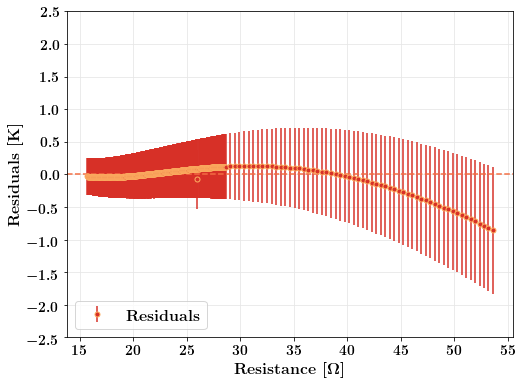

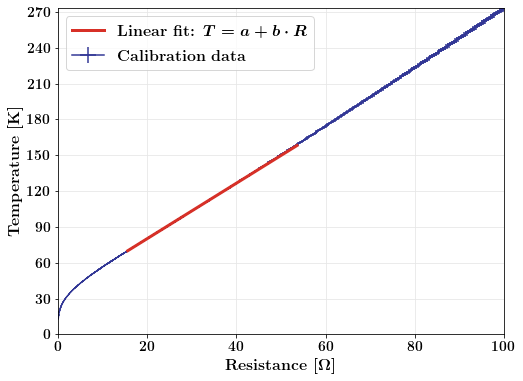

 FCN=8.00308 FROM MIGRAD    STATUS=CONVERGED      68 CALLS          69 TOTAL
                     EDM=4.60921e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           3.36194e+01   1.18441e-01   4.30825e-05  -2.85073e-03
   2  p1           2.32273e+00   5.25947e-03   1.91312e-06  -2.44042e-01


In [25]:
# Function for finding conversion curve
def find_conversion_curve(data,range_fit=[0,100],par_guess=[0,0]):

    
    def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        
        f = ROOT.TF1("f", "pol1") # Define linear fit model
        
        g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
        f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
        fit = g.Fit('f','S',"")                    # Perform fit
      
        cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
        pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
        print('-------------------------------------------','\n')
        print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
        print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
        print('Chi2: ', f.GetChisquare())
        print('Ndf : ', f.GetNDF()      )
        print('Cov_ab: ',cov_ab)
        print('Pearson coefficient: ', pcoeff,'\n')    
        print('-------------------------------------------')

        x_fit     = np.linspace(x[0], x[-1], 300)
        y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
        y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x
        
        intercept = [f.GetParameter(0),f.GetParError(0)]
        slope     = [f.GetParameter(1),f.GetParError(1)]

        res = (y_fit_res - y)
        err_res = erry
        
        return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  

    
    # Filter data by choosen range 
    minimum = range_fit[0]
    maximum = range_fit[1]
    
    df = data[data['T']>minimum]
    df = df[df['T']<maximum]

    x = np.array(df['R'])
    y = np.array(df['T'])
    errx = np.array(df['Delta_R'])
    erry = np.array(df['Delta_T'])

    # Perform linear fit
    x_fit, y_fit, intercept, slope, res, err_res, cov = linear_fit(x,y,errx,erry,par_guess)
      
        
    # PLOT RESIDUALS
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x,res,yerr=err_res,fmt='o',markerfacecolor=col[8],
                    color=col[6],ecolor=col[8],label=r'\bf{Residuals}',alpha=1,markersize=5)
    #ax.set_title(r'\bf{ }', fontsize=20)
    ax.axhline(0,color=col[7],ls='--')
    ax.set_xlabel(r'\bf{Resistance [$\Omega$]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [K]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    ax.set_xticks(np.arange(15, 60, 5))
    ax.set_yticks(np.arange(-2.5, 3, 0.5))
    ax.set_ylim(-2.5,2.5)
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/Pt100_res.pdf', format='pdf',bbox_inches = "tight")
    

    # PLOT CONVERSION CURVE    
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df_conv['R'],df_conv['T'],yerr=df_conv['Delta_T'],xerr=df_conv['Delta_R'],fmt='-',markerfacecolor=col[0],
                    color=col[0],ecolor=col[0],label=r'\bf{Calibration data}',alpha=1,markersize=5,zorder=1)
    
    label_fit = r'\bf{Linear fit: $T=a+b\cdot R$}'
    
    ax.plot(x_fit,y_fit,color=col[8],linewidth=3,label=label_fit,zorder=2)

    #ax.set_title(r'\bf{Pt100 conversion curve}', fontsize=20)
    ax.set_xlabel(r'\bf{Resistance [$\Omega$]}',fontsize=16)
    ax.set_ylabel(r'\bf{Temperature [K]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_ylim(30,273)
    ax.set_xlim(0,100)
    ax.set_xticks(np.arange(0, 120, 20))
    ax.set_yticks(np.arange(0, 290, 30))
    ax.set_axisbelow(True)
    
    plt.savefig(dir_name+'/Pt100_conversion.pdf', format='pdf',bbox_inches = "tight")
    
    return(intercept, slope)

# Define range to fit
ymin = 70
ymax = 160

# Find conversion coefficients
conv_intercept, conv_slope = find_conversion_curve(df_conv,[ymin,ymax])


In [6]:
# Convert resistance RT to temperature 
df_co['Ts'] = conv_slope[0]*df_co['Rv'] + conv_intercept[0]
df_he['Ts'] = conv_slope[0]*df_he['Rv'] + conv_intercept[0]

df_co['err_Ts'] = np.sqrt( conv_intercept[1]**2 + (df_co['RT']*conv_slope[1])**2 )
df_he['err_Ts'] = np.sqrt( conv_intercept[1]**2 + (df_he['RT']*conv_slope[1])**2 )

df_co.describe()

,ID,Tcf,Rv,Vout,err_Rv,err_Vout,RT,err_RT,rel_err_RT,Ts,err_Ts
count,46.000000,45.000000,46.000000,46.000000,4.600000e+01,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,2545.804348,99.378784,37.293478,380.608696,5.773503e-02,0.349285,37.355738,0.280840,0.007537,120.242010,0.230568
std,320.247933,27.592784,8.475177,15.309370,2.104671e-17,0.012488,8.489326,0.060956,0.000092,19.685522,0.038069
min,1877.000000,53.552000,22.000000,342.000000,5.773503e-02,0.317894,22.036728,0.171953,0.007426,84.719435,0.165715
25%,2343.750000,78.162000,31.125000,373.000000,5.773503e-02,0.343045,31.176962,0.236290,0.007472,105.914319,0.202278
50%,2578.000000,97.281000,36.750000,382.500000,5.773503e-02,0.350803,36.811352,0.276620,0.007515,118.979659,0.226965
75%,2765.750000,117.262000,42.750000,392.000000,5.773503e-02,0.358582,42.821369,0.319942,0.007579,132.916021,0.254465
max,3165.000000,153.750000,54.000000,406.000000,5.773503e-02,0.370082,54.090150,0.401665,0.007803,159.046700,0.308156


## Plot drift dataset

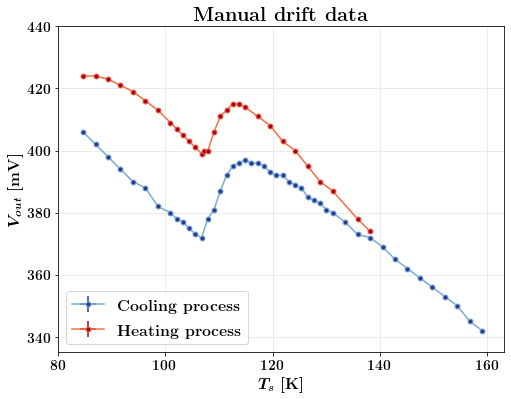

In [7]:
# Plot drift dataset

fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.errorbar(df_co['Ts'],df_co['Vout'],yerr=df_co['err_Vout'],xerr=df_co['err_Ts'],fmt='-o',markerfacecolor=col[0],
            color=col[2],ecolor=col[0],label=r'\bf{Cooling process}',alpha=1,markersize=5)
ax.errorbar(df_he['Ts'],df_he['Vout'],yerr=df_he['err_Vout'],xerr=df_he['err_Ts'],fmt='-o',markerfacecolor=col[9],
            color=col[7],ecolor=col[9],label=r'\bf{Heating process}',alpha=1,markersize=5)

ax.set_title(r'\bf{Manual drift data}', fontsize=20)
ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
ax.set_ylabel(r'\bf{$ V_{out}$ [mV]}',fontsize=16)
ax.grid(color='0.9')
ax.set_ylim(335,435)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.legend(loc='lower left',fontsize=16)
ax.set_yticks(np.arange(340, 460, 20))
ax.set_xticks(np.arange(80, 180, 20))
ax.set_axisbelow(True)

plt.savefig(dir_name+'/drift_data.pdf', format='pdf',bbox_inches = "tight")

## Substract background from cooling and heating data

In [8]:
# Find minimum
def minimum_Tc(data,minimum,maximum):
    
    df = data[data['Tcf']>minimum]
    df = df[df['Tcf']<maximum]

    indx_min = np.argmin(df['Vout'])
    Tc_min = [df.iloc[indx_min]['Ts'],df.iloc[indx_min]['Vout']]
    
    print('Minimum:', Tc_min)
    
    return(Tc_min)
    
Tc_min_co = minimum_Tc(df_co,60,120)
Tc_min_he = minimum_Tc(df_he,60,120)

Minimum: [106.785341670288, 372.0]
Minimum: [106.785341670288, 399.0]


In [9]:
def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        
    f = ROOT.TF1("f", "pol1") # Define linear fit model
        
    g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
    f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
    fit = g.Fit('f','S',"")                    # Perform fit
      
    cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
    pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
    print('-------------------------------------------','\n')
    print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
    print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
    print('Chi2: ', f.GetChisquare())
    print('Ndf : ', f.GetNDF()      )
    print('Cov_ab: ',cov_ab)
    print('Pearson coefficient: ', pcoeff,'\n')
        
    print('-------------------------------------------')

    x_fit     = np.linspace(x[0], x[-1], 300)
    y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
    y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x
        
    intercept = [f.GetParameter(0),f.GetParError(0)]
    slope     = [f.GetParameter(1),f.GetParError(1)]

    res = (y_fit_res - y)
    err_res = erry
        
    return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  

In [10]:
def quadratic_fit(x,y,errx,erry,par_guess=[0,0]):

    # Quadratic fit y = a + b x + c x**2
        
    f = ROOT.TF1("f", "pol2") # Define linear fit model
        
    g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                              errx.astype(np.double), erry.astype(np.double))
        
    f.SetParameters(par_guess[0],par_guess[1],par_guess[2]) # Set initial parameters
    fit = g.Fit('f','S',"")                    # Perform fit
      
    cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
    pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient
        
        
    print('-------------------------------------------','\n')
    print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
    print('b: ', f.GetParameter(1),'+-',f.GetParError(1))
    print('c: ', f.GetParameter(2),'+-',f.GetParError(2),'\n')
    print('Chi2: ', f.GetChisquare())
    print('Ndf : ', f.GetNDF()      )
    print('Cov_ab: ',cov_ab)
    print('Pearson coefficient: ', pcoeff,'\n')
    print('-------------------------------------------')

    x_fit     = np.linspace(x[0], x[-1], 300)
    y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit + f.GetParameter(2)*(x_fit**2)
    y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x + f.GetParameter(2)*(x**2)
        
    a = [f.GetParameter(0),f.GetParError(0)]
    b = [f.GetParameter(1),f.GetParError(1)]
    c = [f.GetParameter(2),f.GetParError(2)]
    
    res = (y_fit_res - y)
    err_res = erry
        
    return(x_fit,y_fit,a,b,c,res,err_res,cov_ab)  

------------------------------------------- 

a:  536.2883852847611 +- 1.7400143490688758
b:  -1.546739237852267 +- 0.017860904847730535 

Chi2:  30.049316076662006
Ndf :  11
Cov_ab:  -0.03099558750597044
Pearson coefficient:  (-0.9979997521962234, 1.5183022540205344e-14) 

-------------------------------------------


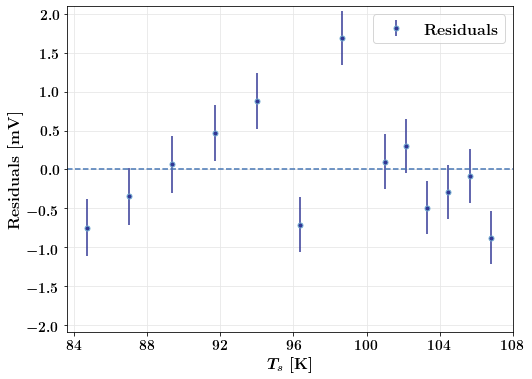

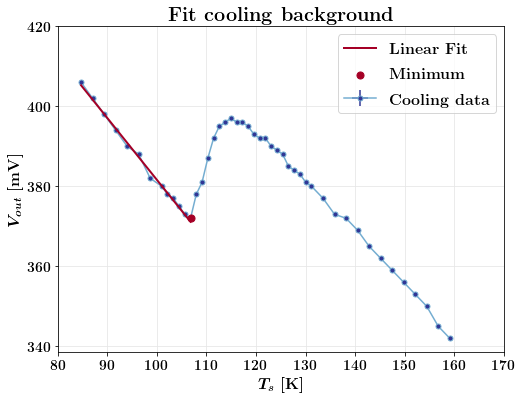

 FCN=30.0493 FROM MIGRAD    STATUS=CONVERGED     202 CALLS         203 TOTAL
                     EDM=1.57933e-10    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.36288e+02   1.74001e+00   3.45024e-04  -1.15669e-06
   2  p1          -1.54674e+00   1.78609e-02   3.54150e-06   8.82637e-04


In [40]:
def substract_background_co(df,minimum,maximum,par_guess):
    
    # Filter data for filtering background
    data = df[df['Ts']>=minimum]
    data = data[data['Ts']<=maximum]

    x = np.array(data['Ts'])
    y = np.array(data['Vout'])
    errx = np.array(data['err_Ts'])
    erry = np.array(data['err_Vout'])

    # Perform linear fit
    x_fit, y_fit, intercept, slope, res, err_res, cov = linear_fit(x,y,errx,erry,par_guess)

    # Subtract background to Vout data and compute the corresponding error
    df['Vb'] = df['Vout'] - (intercept[0] + slope[0]*df['Ts']) 
    
    df['err_Vb'] = np.sqrt( df['err_Vout']**2 + intercept[1]**2 
                            + (df['Ts']*slope[1])**2 + (slope[0]*df['err_Ts'])**2 ) 
    
    
    # PLOT RESULTS 
    
    # Plot residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x,res,yerr=err_res,fmt='o',markerfacecolor=col[0],
                    color=col[2],ecolor=col[0],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[1],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper right',fontsize=16)
    ax.set_xticks(np.arange(84, 110, 4))
    ax.set_axisbelow(True)
    ax.set_ylim(-2.1,2.1)
    plt.savefig(dir_name+'/drift_background_res_co.pdf', format='pdf',bbox_inches = "tight")    
    
    # Plot linear fit of background
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Vout'],yerr=df['err_Vout'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[0],
            color=col[2],ecolor=col[0],label=r'\bf{Cooling data}',alpha=1,markersize=5,zorder=1)

    ax.plot(x_fit,y_fit,color=col[9],linewidth=2,label=r'\bf{Linear Fit}',zorder=2)

    ax.scatter(Tc_min_co[0],Tc_min_co[1],color=col[9],ec=col[9],marker='o',s=50,label=r'\bf{Minimum}',zorder=3)
    
    ax.set_title(r'\bf{Fit cooling background}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$ V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xticks(np.arange(80, 180, 10))
    ax.set_yticks(np.arange(340, 440, 20))
    ax.set_axisbelow(True)
    
substract_background_co(df_co,80,106.8,[100,-2])

------------------------------------------- 

a:  575.8773678899068 +- 5.372943619301641
b:  -1.654713185091013 +- 0.05252253045248287 

Chi2:  1.9667451608692006
Ndf :  6
Cov_ab:  -0.28205251692169403
Pearson coefficient:  (-0.9990195613194305, 2.35440903152199e-09) 

-------------------------------------------


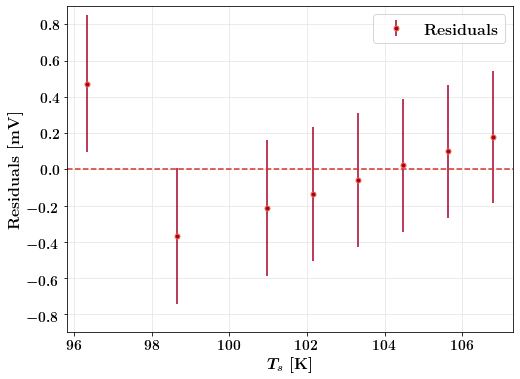

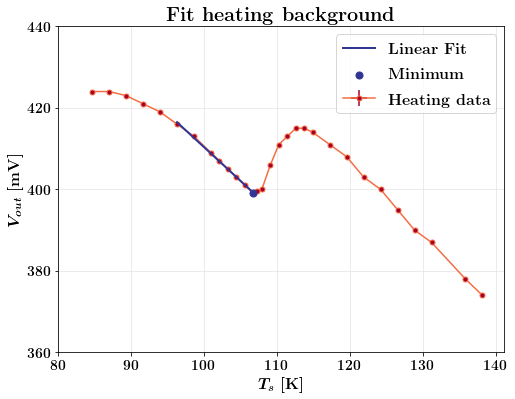

 FCN=1.96675 FROM MIGRAD    STATUS=CONVERGED     174 CALLS         175 TOTAL
                     EDM=2.66797e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           5.75877e+02   5.37294e+00   2.74600e-04   2.81720e-04
   2  p1          -1.65471e+00   5.25225e-02   1.43080e-06   2.98352e-02


In [33]:
def substract_background_he(df,minimum,maximum,par_guess):
    
    # Filter data for filtering background
    data = df[df['Ts']>=minimum]
    data = data[data['Ts']<=maximum]

    x = np.array(data['Ts'])
    y = np.array(data['Vout'])
    errx = np.array(data['err_Ts'])
    erry = np.array(data['err_Vout'])

    # Perform linear fit
    x_fit, y_fit, a, b, res, err_res, cov = linear_fit(x,y,errx,erry,par_guess)

    # Subtract background to Vout data and compute the corresponding error
    df['Vb'] = df['Vout'] - (a[0] + b[0]*df['Ts']) # + c[0]*(df['Ts']**2))
    
    df['err_Vb'] = np.sqrt( df['err_Vout']**2 + a[1]**2 
                            + (df['Ts']*b[1])**2 + (b[0]*df['err_Ts'])**2 )/2
    
    
    # PLOT RESULTS
    
    
    # Plot residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x,res,yerr=err_res,fmt='o',markerfacecolor=col[9],
                    color=col[7],ecolor=col[9],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[8],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='upper right',fontsize=16)
    #ax.set_xticks(np.arange(96, 110, 2))
    ax.set_ylim(-0.9,0.9)
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/drift_background_res_he.pdf', format='pdf',bbox_inches = "tight")
    
    # Plot linear fit of background
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Vout'],yerr=df['err_Vout'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[9],
            color=col[7],ecolor=col[9],label=r'\bf{Heating data}',alpha=1,markersize=5,zorder=1)

    ax.plot(x_fit,y_fit,color=col[0],linewidth=2,label=r'\bf{Linear Fit}',zorder=2)

    ax.scatter(Tc_min_he[0],Tc_min_he[1],color=col[0],ec=col[0],marker='o',s=50,zorder=3,label=r'\bf{Minimum}')
    
    ax.set_title(r'\bf{Fit heating background}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$ V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xticks(np.arange(80, 150, 10))
    ax.set_yticks(np.arange(360, 460, 20))
    ax.set_axisbelow(True)
    
#substract_background_he(df_he,96,106.8,[100,-0.5,-1]) #98
substract_background_he(df_he,96,106.8,[100,-2]) #98

## Plot data without background

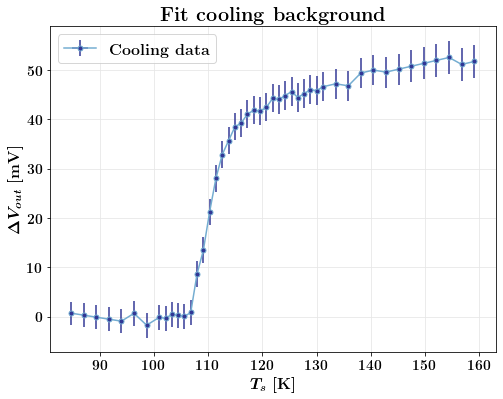

In [13]:
def plot_co(df):    
    
    # PLOT RESULTS
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Vb'],yerr=df['err_Vb'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[0],
            color=col[2],ecolor=col[0],label=r'\bf{Cooling data}',alpha=1,markersize=5,zorder=1)
    
    ax.set_title(r'\bf{Fit cooling background}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$\Delta V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    #ax.set_xticks(np.arange(80, 180, 10))
    #ax.set_yticks(np.arange(340, 440, 20))
    ax.set_axisbelow(True)
    
plot_co(df_co)

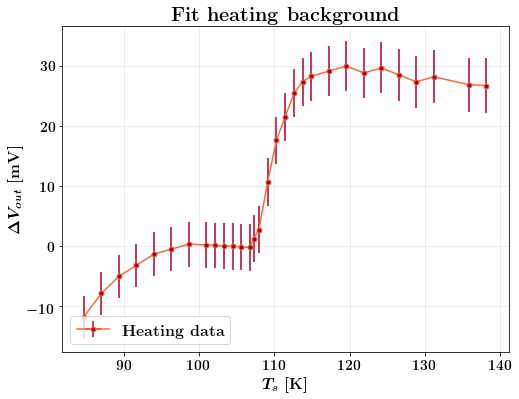

In [14]:
def plot_he(df):
        
    # PLOT RESULTS
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Vb'],yerr=df['err_Vb'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[9],
            color=col[7],ecolor=col[9],label=r'\bf{Heating data}',alpha=1,markersize=5,zorder=1)
    
    ax.set_title(r'\bf{Fit heating background}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$ \Delta V_{out}$ [mV]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    #ax.set_xticks(np.arange(80, 150, 10))
    #ax.set_yticks(np.arange(360, 460, 20))
    ax.set_axisbelow(True)
    
plot_he(df_he)

## Convert from DeltaVout to Rsc

In [15]:
# Compute R0 and V0 errors

R0 = 995 # K Ohm
err_R0 = 1/np.sqrt(3)*np.sqrt( (0.009*R0)**2 + 0.001**2 )
print('R0:', R0,'+-',err_R0,' Ohm')

V0 = 6
err_V0 = (1/np.sqrt(3))*np.sqrt( (0.0015*V0)**2 + 0.002**2 )
print('V0:', V0,'+-',err_V0,' V')

I = V0/R0
err_I = np.sqrt( (1/R0)**2 * err_V0**2 + (V0/R0**2)**2 * err_R0**2 )
print('I:', I,'+-',err_I, ' V/Ohm')

RG = 98.5 # Ohm
err_RG = 1/np.sqrt(3)*np.sqrt( (0.009*RG)**2 + 0.002**2 )
print('RG:', RG,'+-',err_RG,' Ohm')

G = 1 + 50*10**3/RG
err_G = np.sqrt( (50*10**3/RG**2)**2 * err_RG**2 )
print('G:', G,'+-',err_G)


R0: 995 +- 5.170171692829295  Ohm
V0: 6 +- 0.005322906474223773  V
I: 0.006030150753768844 +- 3.1786981725562934e-05  V/Ohm
RG: 98.5 +- 0.5118223161736243  Ohm
G: 508.61421319796955 +- 2.637647536260271


In [16]:
# Convert Vb to Rsc
#df_co['Rsc'] = df_co['Vb']/V0 * R0/G

#df_co['Vb_V'] = df_co['Vb']*10**(-3)
#df_co['err_Vb_V'] = df_co['err_Vb']*10**(-3)
#df_he['Vb_V'] = df_he['Vb']*10**(-3)
#df_he['err_Vb_V'] = df_he['err_Vb']*10**(-3)

df_co['Rsc'] = (R0*df_co['Vb']/(V0*G)) * (1-df_co['Vb']/(V0*G))**(-1)

df_co['err_Rsc'] = np. sqrt( (R0/(V0*G))**2 * (df_co['err_Vb']**2)
                           + (df_co['Vb']/(V0*G))**2 * err_R0**2
                           + (df_co['Vb']*R0/(V0**2 * G))**2 * err_V0**2
                           + (df_co['Vb']*R0/(V0 * G**2))**2 * err_G**2 )

df_he['Rsc'] = df_he['Vb']/V0 * R0/G
df_he['err_Rsc'] = np. sqrt( (R0/(V0*G))**2 * (df_he['err_Vb']**2)
                           + (df_he['Vb']/(V0*G))**2 * err_R0**2
                           + (df_he['Vb']*R0/(V0**2 * G))**2 * err_V0**2
                           + (df_he['Vb']*R0/(V0 * G**2))**2 * err_G**2 )

df_co.head()

,ID,Tcf,Rv,Vout,err_Rv,err_Vout,RT,err_RT,rel_err_RT,Ts,err_Ts,Vb,err_Vb,Rsc,err_Rsc
0,1877,153.750,54.0,342,0.057735,0.317894,54.090150,0.401665,0.007426,159.046700,0.308156,51.715386,3.380173,17.152442,1.109134
1,1929,150.854,53.0,345,0.057735,0.320316,53.088481,0.394382,0.007429,156.723973,0.303300,51.122733,3.344552,16.952527,1.097433
2,1977,147.958,52.0,350,0.057735,0.324358,52.086811,0.387103,0.007432,154.401246,0.298457,52.530080,3.309249,17.427384,1.086386
3,2027,144.483,51.0,353,0.057735,0.326788,51.085142,0.379826,0.007435,152.078519,0.293628,51.937427,3.273954,17.227361,1.074790
4,2088,139.850,50.0,356,0.057735,0.329219,50.083472,0.372553,0.007439,149.755792,0.288816,51.344774,3.238829,17.027417,1.063249


## Find interception of transition with zero 

In [17]:
# Function for finding interception between two lines
def interception(param1,param2,string1='',string2='',cov_param1=0,cov_param2=0):
        
    # a + b x
    a, erra = param1[0]
    b, errb = param1[1]
    
    # c + d x
    c, errc = param2[0]
    d, errd = param2[1]  
    
    x = (a-c)/(d-b)
    y = a + b * x
    
    errx = np.sqrt( (1/(d-b) * erra)**2 + ( (a-c)/(d-b)**2 * errb )**2 +
                     (-1/(d-b) * errc)**2 + (-(a-c)/(d-b)**2 * errd)**2 -
                    2*(a-c)/((d-b)**3) * (cov_param1-cov_param2) )
 
    erry = np.sqrt( erra**2 + (x*errb)**2 + (b*errx)**2 )
    
    xx = [x,errx]
    yy = [y,erry]

    #print('Linear fit a+bx: '+string1)
    #print('a=',a,'+-',erra)
    #print('b=',b,'+-',errb,'\n')

    #print('Linear fit c+dx: '+string2)
    #print('c=',c,'+-',errc)
    #print('d=',d,'+-',errd,'\n')
    
    print('-------------------------------------------','\n')
    print('Interception:')
    print('xp=',xx[0],'+-',xx[1])
    print('yp=',yy[0],'+-',yy[1],'\n')
    print('-------------------------------------------','\n')
    
    return xx, yy


------------------------------------------- 

a:  -181.4826390306358 +- 16.91932737706667
b:  1.7058641871534972 +- 0.1534978539721366 

Chi2:  1.62176304554789
Ndf :  5
Cov_ab:  -2.596503480130028
Pearson coefficient:  (0.9933260705485751, 6.963913316096864e-06) 

-------------------------------------------
------------------------------------------- 

Interception:
xp= 106.38750751516048 +- 0.4017894010494321
yp= 0.0 +- 0.0 

------------------------------------------- 



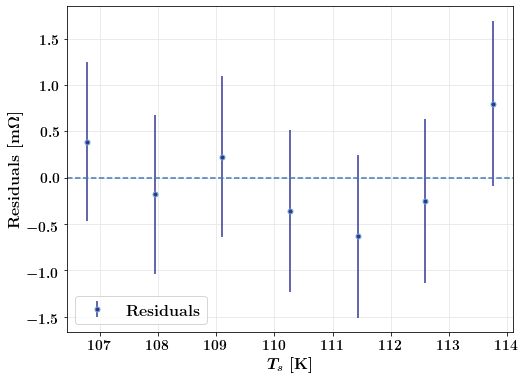

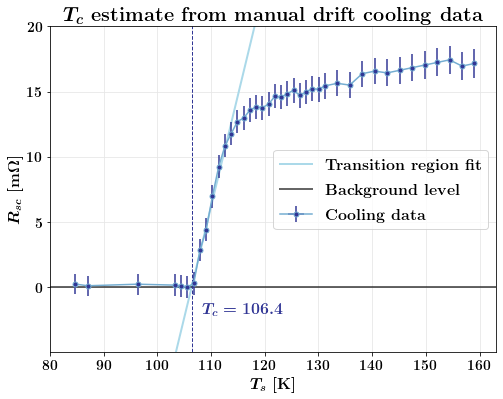

 FCN=1.62176 FROM MIGRAD    STATUS=CONVERGED      63 CALLS          64 TOTAL
                     EDM=2.56476e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -1.81483e+02   1.69193e+01   2.81444e-04   5.36814e-04
   2  p1           1.70586e+00   1.53498e-01   2.55332e-06   5.46611e-02


In [22]:
def plot_co(df,minimum,maximum,par_guess): 
    
    def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        f = ROOT.TF1("f", "pol1") # Define linear fit model

        g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                                  errx.astype(np.double), erry.astype(np.double))

        f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
        fit = g.Fit('f','S',"")                    # Perform fit

        cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
        pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient


        print('-------------------------------------------','\n')
        print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
        print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
        print('Chi2: ', f.GetChisquare())
        print('Ndf : ', f.GetNDF()      )
        print('Cov_ab: ',cov_ab)
        print('Pearson coefficient: ', pcoeff,'\n')

        print('-------------------------------------------')

        x_fit     = np.linspace(x[0]-11, x[-1]+12, 300)
        y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
        y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x

        intercept = [f.GetParameter(0),f.GetParError(0)]
        slope     = [f.GetParameter(1),f.GetParError(1)]

        res = (y_fit_res - y)
        err_res = erry

        return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  
    
    
    # Remove negative resistance from data 
    df = df[df['Rsc']>0]

    # Filter data for filtering transition region
    data = df[df['Ts']>=minimum]
    data = data[data['Ts']<=maximum]
 
    x = np.array(data['Ts'])
    y = np.array(data['Rsc'])
    errx = np.array(data['err_Ts'])
    erry = np.array(data['err_Rsc'])

    # Perform linear fit
    x_fit, y_fit, a, b, res, err_res, cov = linear_fit(x,y,errx,erry,par_guess)

    # Find interception point between y=0 and transition region fit 
    xp, yp = interception([[0,0],[0,0]],[a,b],'Intercetta con zero','Transition region fit',0,cov)
    
        
    # PLOT RESULTS

    # Plot residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x,res,yerr=err_res,fmt='o',markerfacecolor=col[0],
                    color=col[2],ecolor=col[0],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[1],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [m$\Omega$]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    ax.set_xticks(np.arange(107, 115, 1))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/drift_tc_res_co.pdf', format='pdf',bbox_inches = "tight")
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Rsc'],yerr=df['err_Rsc'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[0],
            color=col[2],ecolor=col[0],label=r'\bf{Cooling data}',alpha=1,markersize=5,zorder=2)

    ax.plot(x_fit,y_fit,color=col[3],linewidth=2,label=r'\bf{Transition region fit}',zorder=1)
    ax.axhline(0,color='black',ls='-',linewidth=2,zorder=1,alpha=0.6,label=r'\bf{Background level}')
    
    ax.axvline(xp[0],color=col[0],ls='--',linewidth=1,zorder=1)
    plt.text(xp[0]+2,-2,r'$T_{c}=106.4$',color=col[0],fontsize=16)
    
    ax.set_title(r'\bf{$T_c$ estimate from manual drift cooling data}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$ R_{sc}$ [m$\Omega$]}',fontsize=16)
    ax.grid(color='0.9')
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xticks(np.arange(80, 170, 10))
    ax.set_yticks(np.arange(0, 25, 5))
    ax.set_ylim(-5,20)
    plt.savefig(dir_name+'/drift_tc_co.pdf', format='pdf',bbox_inches = "tight")
    
plot_co(df_co,105.7,114,[100,1])

------------------------------------------- 

a:  -168.0158292144753 +- 31.812775670065694
b:  1.569892820869242 +- 0.28987998899205475 

Chi2:  0.5498911293933197
Ndf :  4
Cov_ab:  -9.220545494079435
Pearson coefficient:  (0.9907184989226947, 0.0001288196100590987) 

-------------------------------------------
------------------------------------------- 

Interception:
xp= 107.02375791580839 +- 0.6073969288579872
yp= 0.0 +- 0.0 

------------------------------------------- 



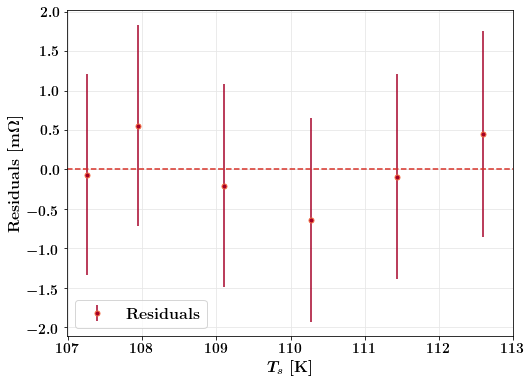

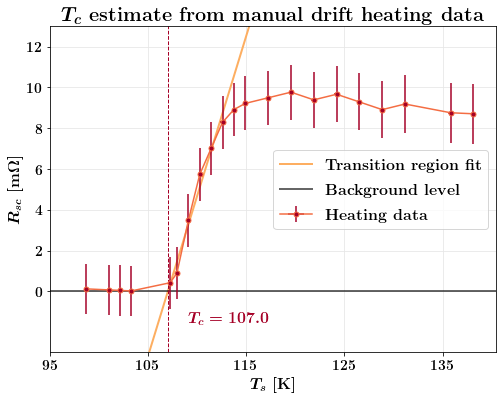

 FCN=0.549891 FROM MIGRAD    STATUS=CONVERGED      57 CALLS          58 TOTAL
                     EDM=2.99343e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -1.68016e+02   3.18128e+01   3.29734e-04  -1.32385e-04
   2  p1           1.56989e+00   2.89880e-01   3.00456e-06  -1.46256e-02


In [23]:
def plot_he(df,minimum,maximum,par_guess): 
    
    def linear_fit(x,y,errx,erry,par_guess=[0,0]):

        f = ROOT.TF1("f", "pol1") # Define linear fit model

        g = ROOT.TGraphErrors(x.size, x.astype(np.double), y.astype(np.double), 
                                  errx.astype(np.double), erry.astype(np.double))

        f.SetParameters(par_guess[0],par_guess[1]) # Set initial parameters
        fit = g.Fit('f','S',"")                    # Perform fit

        cov_ab = fit.GetCovarianceMatrix()[1,0] # Compute covariance term ab
        pcoeff = stats.pearsonr(x, y)           # Compute Pearson coefficient


        print('-------------------------------------------','\n')
        print('a: ', f.GetParameter(0),'+-',f.GetParError(0))
        print('b: ', f.GetParameter(1),'+-',f.GetParError(1),'\n')
        print('Chi2: ', f.GetChisquare())
        print('Ndf : ', f.GetNDF()      )
        print('Cov_ab: ',cov_ab)
        print('Pearson coefficient: ', pcoeff,'\n')
        print('-------------------------------------------')

        x_fit     = np.linspace(x[0]-10, x[-1]+10, 300)
        y_fit     = f.GetParameter(0) + f.GetParameter(1)*x_fit
        y_fit_res = f.GetParameter(0) + f.GetParameter(1)*x

        intercept = [f.GetParameter(0),f.GetParError(0)]
        slope     = [f.GetParameter(1),f.GetParError(1)]

        res = (y_fit_res - y)
        err_res = erry

        return(x_fit,y_fit,intercept,slope,res,err_res,cov_ab)  
    
    
    # Remove negative resistance from data 
    df = df[df['Rsc']>0]

    # Filter data for filtering transition region
    data = df[df['Ts']>=minimum]
    data = data[data['Ts']<=maximum]
 
    x = np.array(data['Ts'])
    y = np.array(data['Rsc'])
    errx = np.array(data['err_Ts'])
    erry = np.array(data['err_Rsc'])

    # Perform linear fit
    x_fit, y_fit, a, b, res, err_res, cov = linear_fit(x,y,errx,erry,par_guess)

    # Find interception point between y=0 and transition region fit 
    xp, yp = interception([[0,0],[0,0]],[a,b],'Intercetta con zero','Transition region fit',0,cov)
    
    
    # PLOT RESULTS

    # Plot residuals
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(x,res,yerr=err_res,fmt='o',markerfacecolor=col[9],
                    color=col[7],ecolor=col[9],label=r'\bf{Residuals}',alpha=1,markersize=5)
    ax.axhline(0,color=col[8],ls='--')
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{Residuals [m$\Omega$]}',fontsize=16)
    ax.grid(color='0.9')
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='lower left',fontsize=16)
    ax.set_xticks(np.arange(107, 114, 1))
    ax.set_axisbelow(True)
    plt.savefig(dir_name+'/drift_tc_res_he.pdf', format='pdf',bbox_inches = "tight")
    
    # Plot 
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    
    ax.errorbar(df['Ts'],df['Rsc'],yerr=df['err_Rsc'],xerr=df['err_Ts'],fmt='-o',markerfacecolor=col[9],
            color=col[7],ecolor=col[9],label=r'\bf{Heating data}',alpha=1,markersize=5,zorder=2)

    ax.plot(x_fit,y_fit,color=col[6],linewidth=2,label=r'\bf{Transition region fit}',zorder=1)
    ax.axhline(0,color='black',ls='-',linewidth=2,zorder=1,alpha=0.6,label=r'\bf{Background level}')
 
    ax.axvline(xp[0],color=col[9],ls='--',linewidth=1,zorder=1)
    plt.text(xp[0]+2,-1.5,r'$T_{c}=107.0$',color=col[9],fontsize=16)
    
    ax.set_title(r'\bf{$T_c$ estimate from manual drift heating data}', fontsize=20)
    ax.set_xlabel(r'\bf{$T_{s}$ [K]}',fontsize=16)
    ax.set_ylabel(r'\bf{$ R_{sc}$ [m$\Omega$]}',fontsize=16)
    ax.grid(color='0.9')
    ax.set_axisbelow(True)
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    plt.legend(loc='best',fontsize=16)
    ax.set_xticks(np.arange(95, 140, 10))
    ax.set_yticks(np.arange(0, 14, 2))
    ax.set_ylim(-3,13)
    plt.savefig(dir_name+'/drift_tc_he.pdf', format='pdf',bbox_inches = "tight")
    
plot_he(df_he,105.7,113,[100,1])

## Others

In [20]:
# Wighted average between cooling and heating Tc estimates
Tc_co = [106.38750751516048,0.4017894010494321]
Tc_he = [107.02375791580839,0.6073969288579872]

average = np.average([Tc_co[0], Tc_he[0]], weights=[1/(Tc_co[1]**2), 1/(Tc_he[1]**2)])
error_average = np.sqrt( 1/(1/(Tc_co[1]**2)+1/(Tc_he[1]**2)) )

compatibility = np.abs(Tc_co[0]-Tc_he[0])/np.sqrt(Tc_co[1]**2+Tc_he[1]**2)

print('Weighted average:', average,'+-',error_average)
print('Compatibility:', compatibility)

Weighted average: 106.58117180564949 +- 0.33510687035984354
Compatibility: 0.8736557363734319


## Chi square analysis

In [44]:
from scipy.stats import chi2

# interpret test-statistic

dof = 24
chi = 262.6
prob = 0.95

critical = chi2.ppf(prob, dof)

print('Theory:',critical,'at',prob*100,'%')
print('Experimental:',chi,'\n')


if abs(chi) >= critical:
    print('Dependent (reject H0)\n')
else:
    print('Independent (fail to reject H0)','\n')

p_val = 1 - chi2.cdf(chi, dof)
print('P-value:',p_val)
print('1-P-value:',1-p_val,'\n')

# interpret p-value
alpha = 1.0 - prob
if p_val <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    

Theory: 36.41502850180731 at 95.0 %
Experimental: 262.6 

Dependent (reject H0)

P-value: 0.0
1-P-value: 1.0 

Dependent (reject H0)
